Information data DataSet:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15120 entries, 0 to 15119
Data columns (total 15 columns):
Id        15120 non-null int64
p1        12156 non-null float64
p2        12188 non-null float64
p3        12096 non-null float64
p4        12071 non-null float64
p5        12083 non-null float64
p6        12057 non-null float64
p7        12151 non-null float64
p8        12035 non-null float64
p9        12073 non-null float64
p10       12152 non-null float64
p11       12031 non-null float64
p12       12031 non-null float64
p13       12198 non-null float64
target    15120 non-null int64
dtypes: float64(13), int64(2)
memory usage: 1.7 MB
None
Statistics Information  DataSet:
                Id            p1            p2      ...                p12           p13        target
count  15120.00000  12156.000000  12188.000000      ...       12031.000000  12198.000000  15120.000000
mean    7560.50000   2746.864676    155.722432      ...           0.032250     

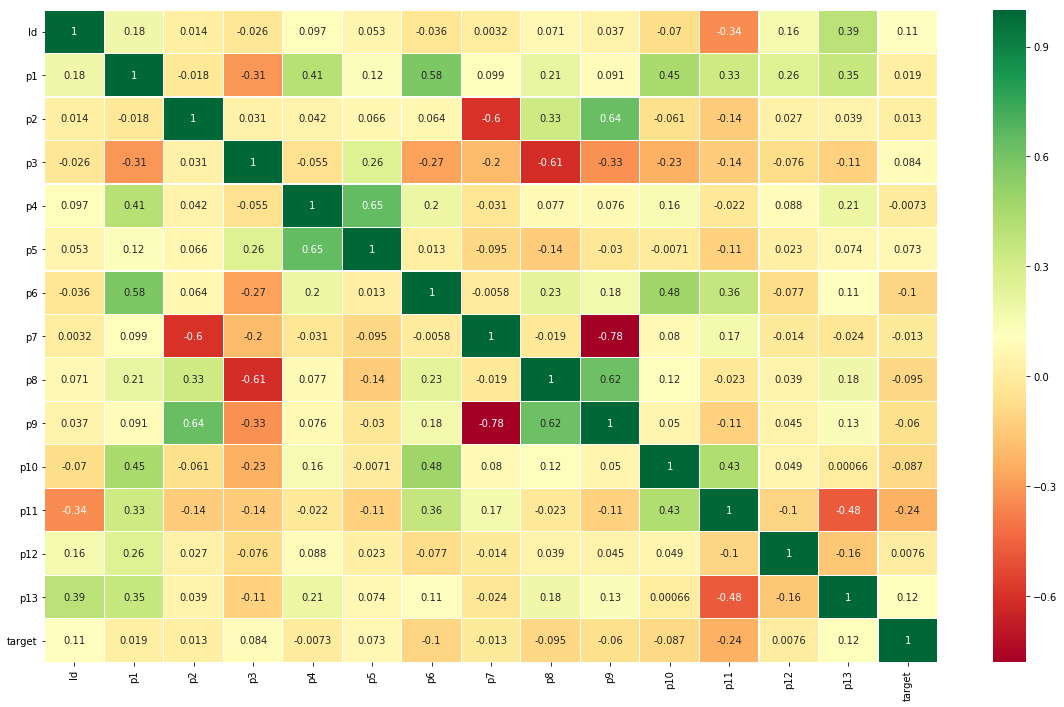

In [18]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt     
get_ipython().magic('matplotlib inline')
import seaborn as sns               
from IPython.display import display


#***************Read DataSet*************************
mytest_mod=pd.read_csv('D:/Communer/train-missings.csv')
print("======================================================================================")
print("Information data DataSet:")
print("======================================================================================")
print(mytest_mod.info())
print("======================================================================================")
print("Statistics Information  DataSet:")
print("======================================================================================")
print(mytest_mod.describe())
print("Correlations:")
print(mytest_mod.corr())
print("======================================================================================")
#****************************************

# #***************visualize correlation DataSet*************************
corrMat = mytest_mod.corr()
sns.heatmap(corrMat,annot=True,cmap='RdYlGn',linewidths=0.2) #data.corr()-->correlation matrix
fig=plt.gcf()
fig.set_size_inches(20,12)
plt.show()

In [26]:
import numpy as np
import pandas as pd
from collections import defaultdict
from scipy.stats import hmean
from scipy.spatial.distance import cdist
from scipy import stats
import numbers


def weighted_hamming(data):
    
    categories_dist = []
    
    for category in data:
        X = pd.get_dummies(data[category])
        X_mean = X * X.mean()
        X_dot = X_mean.dot(X.transpose())
        X_np = np.asarray(X_dot.replace(0,1,inplace=False))
        categories_dist.append(X_np)
    categories_dist = np.array(categories_dist)
    distances = hmean(categories_dist, axis=0)
    return distances


def distance_matrix(data, numeric_distance = "euclidean", categorical_distance = "jaccard"):
    
    possible_continuous_distances = ["euclidean", "cityblock"]
    possible_binary_distances = ["euclidean", "jaccard", "hamming", "weighted-hamming"]
    number_of_variables = data.shape[1]
    number_of_observations = data.shape[0]

    is_numeric = [all(isinstance(n, numbers.Number) for n in data.iloc[:, i]) for i, x in enumerate(data)]
    is_all_numeric = sum(is_numeric) == len(is_numeric)
    is_all_categorical = sum(is_numeric) == 0
    is_mixed_type = not is_all_categorical and not is_all_numeric

    if numeric_distance not in possible_continuous_distances:
        print ("The continuous distance " + numeric_distance + " is not supported.")
        return None
    elif categorical_distance not in possible_binary_distances:
        print ("The binary distance " + categorical_distance + " is not supported.")
        return None

    if is_mixed_type:
        number_of_numeric_var = sum(is_numeric)
        number_of_categorical_var = number_of_variables - number_of_numeric_var
        data_numeric = data.iloc[:, is_numeric]
        data_numeric = (data_numeric - data_numeric.mean()) / (data_numeric.max() - data_numeric.min())
        data_categorical = data.iloc[:, [not x for x in is_numeric]]

  
    if is_mixed_type:
        data_numeric.fillna(data_numeric.mean(), inplace=True)
        for x in data_categorical:
            data_categorical[x].fillna(data_categorical[x].mode()[0], inplace=True)
    elif is_all_numeric:
        data.fillna(data.mean(), inplace=True)
    else:
        for x in data:
            data[x].fillna(data[x].mode()[0], inplace=True)

    if not is_all_numeric and not (categorical_distance == 'hamming' or categorical_distance == 'weighted-hamming'):
        if is_mixed_type:
            data_categorical = pd.get_dummies(data_categorical)
        else:
            data = pd.get_dummies(data)
    elif not is_all_numeric and categorical_distance == 'hamming':
        if is_mixed_type:
            data_categorical = pd.DataFrame([pd.factorize(data_categorical[x])[0] for x in data_categorical]).transpose()
        else:
            data = pd.DataFrame([pd.factorize(data[x])[0] for x in data]).transpose()

    if is_all_numeric:
        result_matrix = cdist(data, data, metric=numeric_distance)
    elif is_all_categorical:
        if categorical_distance == "weighted-hamming":
            result_matrix = weighted_hamming(data)
        else:
            result_matrix = cdist(data, data, metric=categorical_distance)
    else:
        result_numeric = cdist(data_numeric, data_numeric, metric=numeric_distance)
        if categorical_distance == "weighted-hamming":
            result_categorical = weighted_hamming(data_categorical)
        else:
            result_categorical = cdist(data_categorical, data_categorical, metric=categorical_distance)
        result_matrix = np.array([[1.0*(result_numeric[i, j] * number_of_numeric_var + result_categorical[i, j] *
                               number_of_categorical_var) / number_of_variables for j in range(number_of_observations)] for i in range(number_of_observations)])

    np.fill_diagonal(result_matrix, np.nan)

    return pd.DataFrame(result_matrix)


def knn_impute(target, attributes, k_neighbors, aggregation_method="mean", numeric_distance="euclidean",
               categorical_distance="jaccard", missing_neighbors_threshold = 0.5):
   

    possible_aggregation_method = ["mean", "median", "mode"]
    number_observations = len(target)
    is_target_numeric = all(isinstance(n, numbers.Number) for n in target)

    if number_observations < 3:
        print ("Not enough observations.")
        return None
    if attributes.shape[0] != number_observations:
        print("The number of observations in the attributes variable is not matching the target variable length.")
        return None
    if k_neighbors > number_observations or k_neighbors < 1:
        print ("The range of the number of neighbors is incorrect.")
        return None
    if aggregation_method not in possible_aggregation_method:
        print ("The aggregation method is incorrect.")
        return None
    if not is_target_numeric and aggregation_method != "mode":
        print ("The only method allowed for categorical target variable is the mode.")
        return None

    target = pd.DataFrame(target)
    attributes = pd.DataFrame(attributes)

    distances = distance_matrix(attributes, numeric_distance, categorical_distance)
    if distances is None:
        return None

    for i, value in enumerate(target.iloc[:, 0]):
        if pd.isnull(value):
            order = distances.iloc[i,:].values.argsort()[:k_neighbors]
            closest_to_target = target.iloc[order, :]
            missing_neighbors = [x for x  in closest_to_target.isnull().iloc[:, 0]]
            if sum(missing_neighbors) >= missing_neighbors_threshold * k_neighbors:
                continue
            elif aggregation_method == "mean":
                target.iloc[i] = np.ma.mean(np.ma.masked_array(closest_to_target,np.isnan(closest_to_target)))
            elif aggregation_method == "median":
                target.iloc[i] = np.ma.median(np.ma.masked_array(closest_to_target,np.isnan(closest_to_target)))
            else:
                target.iloc[i] = stats.mode(closest_to_target, nan_policy='omit')[0][0]

    return target

In [28]:


knn_impute(target=mytest_mod['p1'], attributes=mytest_mod.drop(['p1', 'Id'], 1),
           aggregation_method="mod", k_neighbors=10, numeric_distance='euclidean',
           categorical_distance='hamming', missing_neighbors_threshold=0.8)


knn_impute(target=mytest_mod['p2'], attributes=mytest_mod.drop(['p2', 'Id'], 1),
                                    aggregation_method="mod", k_neighbors=10, numeric_distance='euclidean',
                                    categorical_distance='hamming', missing_neighbors_threshold=0.8)



knn_impute(target=mytest_mod['p3'], attributes=mytest_mod.drop(['p3', 'Id'], 1),
                                    aggregation_method="mod", k_neighbors=10, numeric_distance='euclidean',
                                    categorical_distance='hamming', missing_neighbors_threshold=0.8)


knn_impute(target=mytest_mod['p4'], attributes=mytest_mod.drop(['p4', 'Id'], 1),
                                    aggregation_method="mod", k_neighbors=10, numeric_distance='euclidean',
                                    categorical_distance='hamming', missing_neighbors_threshold=0.8)


knn_impute(target=mytest_mod['p5'], attributes=mytest_mod.drop(['p5', 'Id'], 1),
                                    aggregation_method="mod", k_neighbors=10, numeric_distance='euclidean',
                                    categorical_distance='hamming', missing_neighbors_threshold=0.8)


knn_impute(target=mytest_mod['p6'], attributes=mytest_mod.drop(['p6', 'Id'], 1),
                                    aggregation_method="mod", k_neighbors=10, numeric_distance='euclidean',
                                    categorical_distance='hamming', missing_neighbors_threshold=0.8)


knn_impute(target=mytest_mod['p7'], attributes=mytest_mod.drop(['p7', 'Id'], 1),
                                    aggregation_method="mod", k_neighbors=10, numeric_distance='euclidean',
                                    categorical_distance='hamming', missing_neighbors_threshold=0.8)


knn_impute(target=mytest_mod['p8'], attributes=mytest_mod.drop(['p8', 'Id'], 1),
                                    aggregation_method="mod", k_neighbors=10, numeric_distance='euclidean',
                                    categorical_distance='hamming', missing_neighbors_threshold=0.8)


knn_impute(target=mytest_mod['p9'], attributes=mytest_mod.drop(['p9', 'Id'], 1),
                                    aggregation_method="mod", k_neighbors=10, numeric_distance='euclidean',
                                    categorical_distance='hamming', missing_neighbors_threshold=0.8)



knn_impute(target=mytest_mod['p10'], attributes=mytest_mod.drop(['p10', 'Id'], 1),
                                    aggregation_method="mod", k_neighbors=10, numeric_distance='euclidean',
                                    categorical_distance='hamming', missing_neighbors_threshold=0.8)


knn_impute(target=mytest_mod['p11'], attributes=mytest_mod.drop(['p11', 'Id'], 1),
                                    aggregation_method="mod", k_neighbors=10, numeric_distance='euclidean',
                                    categorical_distance='hamming', missing_neighbors_threshold=0.8)


knn_impute(target=mytest_mod['p12'], attributes=mytest_mod.drop(['p12', 'Id'], 1),
                                    aggregation_method="mod", k_neighbors=10, numeric_distance='euclidean',
                                    categorical_distance='hamming', missing_neighbors_threshold=0.8)


knn_impute(target=mytest_mod['p13'], attributes=mytest_mod.drop(['p13', 'Id'], 1),
                                    aggregation_method="mod", k_neighbors=10, numeric_distance='euclidean',
                                    categorical_distance='hamming', missing_neighbors_threshold=0.8)


def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)
clean_dataset(mytest_mod)

The aggregation method is incorrect.
The aggregation method is incorrect.
The aggregation method is incorrect.
The aggregation method is incorrect.
The aggregation method is incorrect.
The aggregation method is incorrect.
The aggregation method is incorrect.
The aggregation method is incorrect.
The aggregation method is incorrect.
The aggregation method is incorrect.
The aggregation method is incorrect.
The aggregation method is incorrect.
The aggregation method is incorrect.


,Id,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12,p13,target
20,21.0,2501.0,71.0,9.0,60.0,8.0,767.0,230.0,223.0,126.0,5547.0,1.0,0.0,0.0,5.0
38,39.0,2749.0,98.0,30.0,124.0,53.0,3316.0,252.0,183.0,36.0,6005.0,1.0,0.0,0.0,5.0
39,40.0,2686.0,354.0,12.0,0.0,0.0,3167.0,200.0,219.0,157.0,6155.0,1.0,0.0,0.0,5.0
89,90.0,2745.0,306.0,11.0,67.0,24.0,2416.0,190.0,234.0,184.0,6428.0,1.0,0.0,0.0,2.0
111,112.0,2818.0,324.0,12.0,242.0,26.0,4156.0,189.0,227.0,177.0,5467.0,1.0,0.0,0.0,1.0
155,156.0,3119.0,200.0,20.0,60.0,0.0,6297.0,208.0,253.0,172.0,2377.0,1.0,0.0,0.0,2.0
241,242.0,2530.0,149.0,1.0,319.0,51.0,234.0,221.0,238.0,154.0,2726.0,1.0,0.0,0.0,2.0
268,269.0,2982.0,175.0,9.0,424.0,56.0,5267.0,225.0,245.0,153.0,6500.0,1.0,0.0,0.0,1.0
282,283.0,2521.0,45.0,10.0,42.0,2.0,408.0,223.0,218.0,129.0,2066.0,1.0,0.0,0.0,2.0
341,342.0,2978.0,27.0,4.0,192.0,13.0,4780.0,218.0,230.0,149.0,5502.0,1.0,0.0,0.0,2.0


In [29]:
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score  
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import cross_val_predict 
from sklearn.metrics import confusion_matrix 
all_features = mytest_mod.drop(["Id","target"],axis=1)
Targeted_feature = mytest_mod["target"]
X_train,X_test,y_train,y_test = train_test_split(all_features,Targeted_feature,test_size=0.3,random_state=42)
X_train.shape,X_test.shape,y_train.shape,y_test.shape




((562, 13), (241, 13), (562,), (241,))

--------------The Accuracy of the model----------------------------
The accuracy of the Random Forest Classifier is 69.71
The cross validated score for Random Forest Classifier is: 66.4


Text(0.5,1.05,'Confusion_matrix')

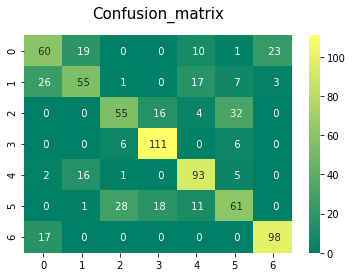

In [30]:
# Random Forests
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(criterion='gini', n_estimators=700,
                             min_samples_split=10,min_samples_leaf=1,
                             max_features='auto',oob_score=True,
                             random_state=1,n_jobs=-1)
model.fit(X_train,y_train)
prediction_rm=model.predict(X_test)
print('--------------The Accuracy of the model----------------------------')
print('The accuracy of the Random Forest Classifier is',round(accuracy_score(prediction_rm,y_test)*100,2))
kfold = KFold(n_splits=10, random_state=22) # k=10, split the data into 10 equal parts
result_rm=cross_val_score(model,all_features,Targeted_feature,cv=10,scoring='accuracy')
print('The cross validated score for Random Forest Classifier is:',round(result_rm.mean()*100,2))
y_pred = cross_val_predict(model,all_features,Targeted_feature,cv=10)
sns.heatmap(confusion_matrix(Targeted_feature,y_pred),annot=True,fmt='3.0f',cmap="summer")
plt.title('Confusion_matrix', y=1.05, size=15)

--------------The Accuracy of the model----------------------------
The accuracy of the K Nearst Neighbors Classifier is 46.47
The cross validated score for K Nearest Neighbors Classifier is: 46.75


Text(0.5,1.05,'Confusion_matrix')

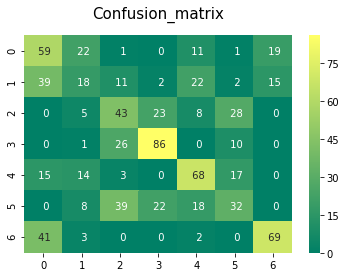

In [31]:
##knn
from sklearn.neighbors import KNeighborsClassifier


model = KNeighborsClassifier(n_neighbors = 4)
model.fit(X_train,y_train)
prediction_knn=model.predict(X_test)
print('--------------The Accuracy of the model----------------------------')
print('The accuracy of the K Nearst Neighbors Classifier is',round(accuracy_score(prediction_knn,y_test)*100,2))
kfold = KFold(n_splits=10, random_state=22) # k=10, split the data into 10 equal parts
result_knn=cross_val_score(model,all_features,Targeted_feature,cv=10,scoring='accuracy')
print('The cross validated score for K Nearest Neighbors Classifier is:',round(result_knn.mean()*100,2))
y_pred = cross_val_predict(model,all_features,Targeted_feature,cv=10)
sns.heatmap(confusion_matrix(Targeted_feature,y_pred),annot=True,fmt='3.0f',cmap="summer")
plt.title('Confusion_matrix', y=1.05, size=15)

--------------The Accuracy of the model----------------------------
The accuracy of the Gradient Boosting Classifier is 63.49
The cross validated score for AdaBoostClassifier is: 64.28


Text(0.5,1.05,'Confusion_matrix')

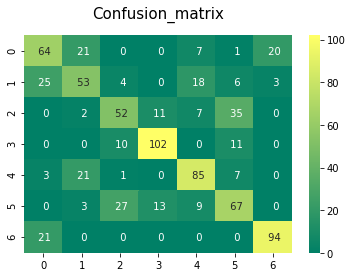

In [32]:
from sklearn.ensemble import GradientBoostingClassifier
model= GradientBoostingClassifier()
model.fit(X_train,y_train)
prediction_gbc=model.predict(X_test)
print('--------------The Accuracy of the model----------------------------')
print('The accuracy of the Gradient Boosting Classifier is',round(accuracy_score(prediction_gbc,y_test)*100,2))
kfold = KFold(n_splits=10, random_state=22) # k=10, split the data into 10 equal parts
result_gbc=cross_val_score(model,all_features,Targeted_feature,cv=10,scoring='accuracy')
print('The cross validated score for AdaBoostClassifier is:',round(result_gbc.mean()*100,2))
y_pred = cross_val_predict(model,all_features,Targeted_feature,cv=10)
sns.heatmap(confusion_matrix(Targeted_feature,y_pred),annot=True,fmt='3.0f',cmap="summer")
plt.title('Confusion_matrix', y=1.05, size=15)